In [27]:
import pandas as pd
import numpy as np
import joblib
from tensorflow import keras

In [5]:

df = pd.read_csv("fake_job_postings.csv")
df.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [6]:
df = df[['title', 'description', 'fraudulent']].dropna()
df.head()

,title,description,fraudulent
0,Marketing Intern,"Food52, a fast-growing, James Beard Award-winn...",0
1,Customer Service - Cloud Video Production,Organised - Focused - Vibrant - Awesome!Do you...,0
2,Commissioning Machinery Assistant (CMA),"Our client, located in Houston, is actively se...",0
3,Account Executive - Washington DC,THE COMPANY: ESRI – Environmental Systems Rese...,0
4,Bill Review Manager,JOB TITLE: Itemization Review ManagerLOCATION:...,0


In [7]:
df['text']=df['title']+" "+df['description']


In [8]:
print(df['fraudulent'].value_counts())

fraudulent
0    17014
1      865
Name: count, dtype: int64


In [9]:
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))




[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [10]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"<.*?>", "", text)
    text = re.sub(r"[^a-z\s]", "", text)
    words = text.split()
    words = [w for w in words if w not in stop_words]
    return " ".join(words)

df['clean_text'] = df['text'].apply(clean_text)


In [12]:
from sklearn.model_selection import train_test_split

X=df['clean_text']
y=df['fraudulent']

X_train,X_test,y_train,y_test=train_test_split(X, y,test_size=0.2,random_state=42)


In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer=TfidfVectorizer(max_features=5000,ngram_range=(1,2))
X_train_vec=vectorizer.fit_transform(X_train)
X_test_vec=vectorizer.transform(X_test)


In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

model=LogisticRegression(max_iter=500)
model.fit(X_train_vec, y_train)

y_pred = model.predict(X_test_vec)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.97      1.00      0.98      3394
           1       0.97      0.35      0.52       182

    accuracy                           0.97      3576
   macro avg       0.97      0.68      0.75      3576
weighted avg       0.97      0.97      0.96      3576

[[3392    2]
 [ 118   64]]


In [15]:
import joblib

joblib.dump(model, "baseline_model.pkl")
joblib.dump(vectorizer, "vectorizer.pkl")


['vectorizer.pkl']

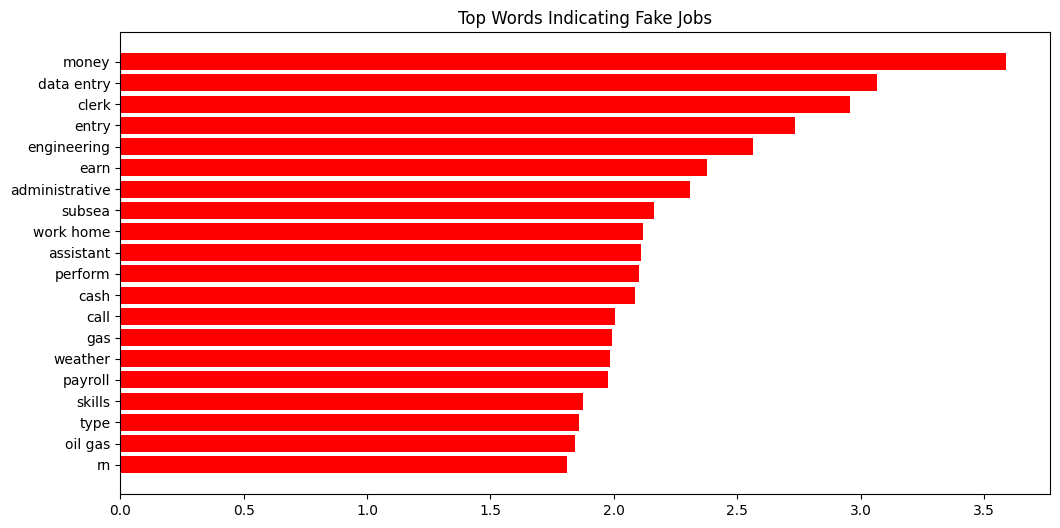

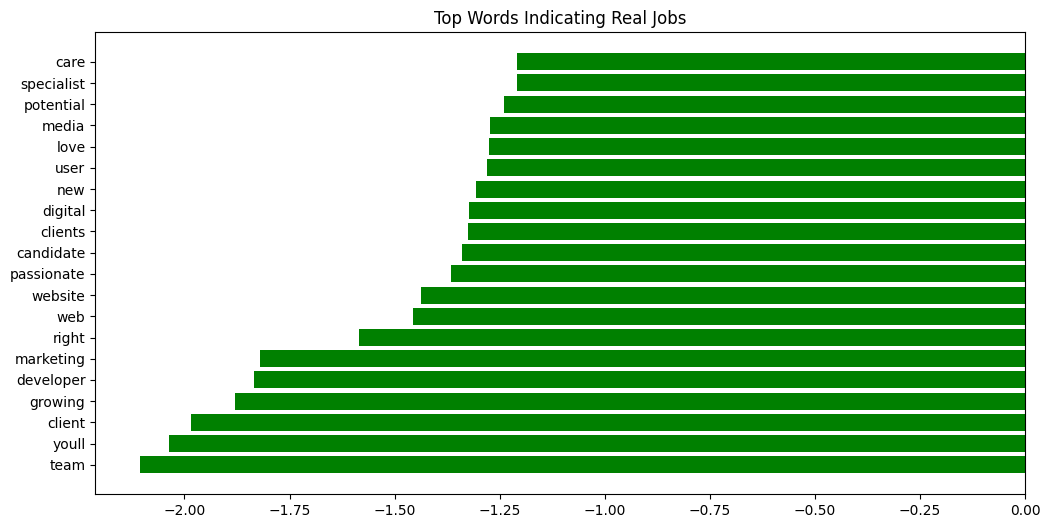

In [19]:
import matplotlib.pyplot as plt

feature_names=np.array(vectorizer.get_feature_names_out())
coefficients=model.coef_[0]

top_fake_idx=np.argsort(coefficients)[-20:]
top_fake_words=feature_names[top_fake_idx]
top_fake_values=coefficients[top_fake_idx]

top_real_idx=np.argsort(coefficients)[:20]
top_real_words=feature_names[top_real_idx]
top_real_values=coefficients[top_real_idx]

plt.figure(figsize=(12,6))
plt.barh(top_fake_words, top_fake_values, color="red")
plt.title("Top Words Indicating Fake Jobs")
plt.show()

plt.figure(figsize=(12,6))
plt.barh(top_real_words, top_real_values, color="green")
plt.title("Top Words Indicating Real Jobs")
plt.show()

In [21]:
 from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

X = df['clean_text'].values
y = df['fraudulent'].values


In [22]:

max_words=10000
max_len=200

tokenizer=Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X)



In [23]:
X_seq=tokenizer.texts_to_sequences(X)
X_pad=pad_sequences(X_seq, maxlen=max_len, padding='post')

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_pad, y, test_size=0.2, random_state=42)

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional

model=Sequential([
    Embedding(input_dim=max_words, output_dim=128, input_length=max_len),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [25]:

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [26]:
history=model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=5,
                    batch_size=128,
                    verbose=1)

Epoch 1/5
112/112 ━━━━━━━━━━━━━━━━━━━━ 104s 820ms/step - accuracy: 0.9329 - loss: 0.2796 - val_accuracy: 0.9715 - val_loss: 0.1044
Epoch 2/5
112/112 ━━━━━━━━━━━━━━━━━━━━ 159s 983ms/step - accuracy: 0.9789 - loss: 0.0672 - val_accuracy: 0.9765 - val_loss: 0.0887
Epoch 3/5
112/112 ━━━━━━━━━━━━━━━━━━━━ 101s 891ms/step - accuracy: 0.9887 - loss: 0.0344 - val_accuracy: 0.9768 - val_loss: 0.1019
Epoch 4/5
112/112 ━━━━━━━━━━━━━━━━━━━━ 137s 852ms/step - accuracy: 0.9949 - loss: 0.0176 - val_accuracy: 0.9801 - val_loss: 0.1104
Epoch 5/5
112/112 ━━━━━━━━━━━━━━━━━━━━ 96s 856ms/step - accuracy: 0.9973 - loss: 0.0099 - val_accuracy: 0.9771 - val_loss: 0.1365


In [28]:
loss, acc=model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {acc:.4f}")

Test Accuracy: 0.9771


In [29]:
from sklearn.metrics import classification_report
y_pred=(model.predict(X_test) > 0.5).astype("int32")
print(classification_report(y_test, y_pred))


112/112 ━━━━━━━━━━━━━━━━━━━━ 7s 56ms/step
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      3394
           1       0.85      0.66      0.75       182

    accuracy                           0.98      3576
   macro avg       0.92      0.83      0.87      3576
weighted avg       0.98      0.98      0.98      3576



In [30]:
model.save("models/bilstm_model.keras")

FileNotFoundError: [Errno 2] No such file or directory: 'models/bilstm_model.keras'

In [ ]:
joblib.dump(tokenizer, "models/tokenizer.pkl")

['models/tokenizer.pkl']

In [ ]:
from google.colab import files
files.download("models/bilstm_model.keras")
files.download("models/tokenizer.pkl")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

FileNotFoundError: [Errno 2] No such file or directory: 'visuals/lstm_accuracy.png'

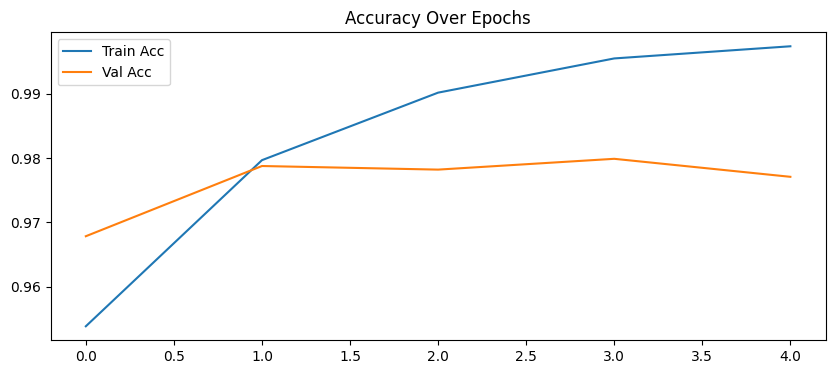

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title("Accuracy Over Epochs")

plt.show()

plt.figure(figsize=(10,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss Over Epochs")

plt.show()
